In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.style.use('ggplot')
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('notebook')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# 准备数据

In [2]:
df1=pd.read_excel('./案例1 新英格兰饲料供应公司.xlsx',sheet_name='每吨营养成分需要量')
df1

,产品,15％猪饲料,40％猪饲料,17％笼养蛋鸡饲料
0,下周需求1吨,400.00,120.00,600.00
1,家禽营养素,0.00,0.00,2675.00
2,猪营养素,3000.00,2500.00,0.00
3,蛋白质,15.00,40.00,17.00
4,钙,0.75,5.50,3.80
5,磷酸盐,0.60,2.50,0.70
6,赖氨酸,0.61,2.00,0.68
7,蛋氨酸,0.20,0.45,0.28
8,甲基胱氨酸,0.30,0.80,0.48
9,色氨酸,0.10,0.25,0.15


## 营养成分下限矩阵

In [3]:
#提取三种产品的营养成分下限向量,与下限矩阵
b1=df1.values[1:,1]
b2=df1.values[1:,2]
b3=df1.values[1:,3]
b=df1.values[1:,1:]
b1,b2,b3
b

array([[0.0, 0.0, 2675.0],
       [3000.0, 2500.0, 0.0],
       [15.0, 40.0, 17.0],
       [0.75, 5.5, 3.8],
       [0.6, 2.5, 0.7],
       [0.61, 2.0, 0.68],
       [0.2, 0.45, 0.28],
       [0.3, 0.8, 0.48],
       [0.1, 0.25, 0.15]], dtype=object)

## 产品需求向量

In [4]:
#提取三种产品的需求向量
demand=df1.values[0,1:]
demand

array([400.0, 120.0, 600.0], dtype=object)

In [5]:
df2=pd.read_excel('./案例1 新英格兰饲料供应公司.xlsx',sheet_name='营养单位吨原料').fillna(0)
df2

,原料,谷物,大麦,豆粉,库存肉粉,石灰,过磷酸钙,市场肉粉
0,每吨成本（美元）,127.00,145.00,314.00,339.00,25.0,405.0,339.00
1,家禽营养素,3500.00,2865.00,2530.00,1984.00,0.0,0.0,1984.00
2,猪营养素,3325.00,2870.00,3485.00,2540.00,0.0,0.0,2540.00
3,蛋白质,8.70,10.00,48.40,50.90,0.0,0.0,50.90
4,钙,0.02,0.06,0.30,9.70,39.0,16.5,9.70
5,磷酸盐,0.28,0.33,0.69,4.02,0.0,21.0,4.02
6,赖氨酸,0.20,0.35,3.20,2.82,0.0,0.0,2.82
7,蛋氨酸,0.20,0.15,0.70,0.62,0.0,0.0,0.62
8,甲基胱氨酸,0.33,0.32,1.44,1.24,0.0,0.0,1.24
9,色氨酸,0.09,0.12,0.63,0.31,0.0,0.0,0.31


## 原料的价格向量

In [6]:

p=df2.values[0,1:]#提取各原料的价格向量
'''——————注意！————————
库存肉粉和市场肉粉已经区分开来了，成为两种原料了
'''
print(p)
p.shape

[127.0 145.0 314.0 339.0 25.0 405.0 339.0]


(7,)

## 各种原料的营养成分矩阵

In [7]:
#提取各种原料的营养成分矩阵
A=df2.values[1:,1:]
A

array([[3500.0, 2865.0, 2530.0, 1984.0, 0.0, 0.0, 1984.0],
       [3325.0, 2870.0, 3485.0, 2540.0, 0.0, 0.0, 2540.0],
       [8.7, 10.0, 48.4, 50.9, 0.0, 0.0, 50.9],
       [0.02, 0.06, 0.3, 9.7, 39.0, 16.5, 9.7],
       [0.28, 0.33, 0.69, 4.02, 0.0, 21.0, 4.02],
       [0.2, 0.35, 3.2, 2.82, 0.0, 0.0, 2.82],
       [0.2, 0.15, 0.7, 0.62, 0.0, 0.0, 0.62],
       [0.33, 0.32, 1.44, 1.24, 0.0, 0.0, 1.24],
       [0.09, 0.12, 0.63, 0.31, 0.0, 0.0, 0.31]], dtype=object)

# 编写循环

$\begin{array}{l}
\min \quad z=c^{\mathrm{T}} \boldsymbol{x} \\
\text { s.t. } & \left\{\begin{array}{l}
\boldsymbol{A} \cdot \boldsymbol{x} \leqslant \boldsymbol{b}, \\
\mathbf{A e q} \cdot \boldsymbol{x}=\mathbf{b e q} \\
\mathbf{L b} \leqslant \boldsymbol{x} \leqslant \mathbf{U b}
\end{array}\right.
\end{array}$

In [13]:
import cvxpy as cp


def solve(p, stride=1, max_price=1000):
    '''
    stride:
        每次循环时，肉粉市场采购价格增长幅度
    max_price：
        肉粉市场采购价格的增长上限
        用来控制循环结束的条件
    '''

    #第一部分，准备列表，储存循环过程中关键变量的变化情况

    price_ls = []  #储存历史市场采购价格
    key_price_ls = []  #储存配方发生变动时的历史市场采购价格

    value_ls = []  #储存历史最优的总生产成本
    x_market_ls = []  #储存三种产品的配方中市场肉粉的历史占比变化
    x_stock_ls = []  #储存三种产品的配方中库存肉粉的历史占比变化

    recipes_ls = []  #储存三种产品的历史配方

    #第二部分，编写优化模型
    '''
        决策矩阵:
            是三类产品的七种原料的占配比量（包括了“市场肉粉”）
            即3*7的矩阵
        目标函数:
            生产预期需求量下的三种产品，所使用的原料的总成本
        约束条件：
            配方限制
                营养下限约束
                总量小于1吨的约束
            库存限制
                库存肉粉只有3吨
                市场肉粉最多72吨 '''
    c = p.copy()  #c为七种原料的价格向量
    #注意，一定要加copy（），不然，会直接修改函数外的p向量的值

    #构造决策矩阵
    x = cp.Variable((7, 3))  #决策变量矩阵
    #构造约束条件
    con = [
        #配方限制
        (A @ x) >= b,  #A为各种原料的营养成分矩阵，9*7；b为三种产品的营养成分下限矩阵,9*3
        cp.sum(x, axis=1, keepdims=True) <= 1,  #总量小于1吨的约束
        #库存限制
        cp.sum(x[-4, :] @ demand) <= 8,  #库存肉粉只有3吨
        cp.sum(x[-1, :] @ demand) <= 72,  #市场肉粉最多72吨
        x >= 0
    ]

    #第三部分，编写循环，模拟随着市场采购价格的升高，最优策略的变化
    while c[-1] <= max_price:
        obj = cp.Minimize(cp.sum(cp.multiply(x.T @ c, demand)))  #构造目标函数
        prob = cp.Problem(obj, con)  #构造模型
        prob.solve(solver='GLPK_MI', verbose=True)  #求解模型

        price_ls.append(c[-1])
        value_ls.append(prob.value)  #储存历次的最低生产成本
        x_market_ls.append(x.value[-1, :])
        x_stock_ls.append(x.value[-4, :])

        recipes_ls.append(x.value)

        #储存配方发生变动时的历史市场采购价格
        if len(price_ls) >= 3:
            if round(value_ls[-1] - value_ls[-2], 1) != round(
                    value_ls[-2] - value_ls[-3], 1):
                #最优总生产成本的斜率转变时，即认为此时产品生产配方发生了变动
                #round（）：鉴于精度问题，进行四舍五入，保留一位小数
                key_price_ls.append(c[-1])

        print('市场肉粉价格为：\n', c[-1])
        print("最优成本为：", prob.value)
        print("最优配方肉粉配比为：\n", x.value[[-4, -1], :])
        print("库存肉粉用量：\n", np.sum(x.value[-4, :] * demand))
        print("市场肉粉用量：\n", np.sum(x.value[-1, :] * demand))

        c[-1] += stride  #不断增加“市场肉粉”的价格
        #注意，“市场肉粉”的初始价格为339，和“库存肉粉”的价格一致

    #最后，return第一部分准备的6个列表
    return price_ls, key_price_ls, value_ls, np.array(x_market_ls), np.array(
        x_stock_ls), np.array(recipes_ls)

# 优化求解

In [14]:
price_ls, key_price_ls, value_ls, x_market_ls, x_stock_ls, recipes_ls = solve(
    p, stride=1, max_price=1000)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Oct 08 08:00:46 PM: Your problem has 21 variables, 5 constraints, and 0 parameters.
(CVXPY) Oct 08 08:00:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 08 08:00:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 08 08:00:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 08 08:00:46 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Oct 08 08:00:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [10]:
len(key_price_ls)

6

In [22]:
np.array(key_price_ls).astype(int)-339

array([ 40,  41,  60,  61, 450, 451])

In [25]:
recipes_ls[[ 0,1,40,  41,  60,  61, 450, 451]][::2] #历史上的所有产品配方矩阵（总共有四个产品配方矩阵）

array([[[ 0.39877893, -0.        ,  0.60122107],
        [ 0.39247616, -0.        , -0.        ],
        [ 0.1571459 ,  0.47107005,  0.1740238 ],
        [-0.        , -0.        ,  0.01333333],
        [ 0.01216907,  0.03690489,  0.07646898],
        [ 0.01192353,  0.03888175,  0.00701289],
        [-0.        ,  0.3379216 ,  0.05241568]],

       [[ 0.41338906, -0.        ,  0.58661094],
        [ 0.37413796, -0.        , -0.        ],
        [ 0.15830859,  0.47107005,  0.24579514],
        [-0.        ,  0.06666667, -0.        ],
        [ 0.01215751,  0.03690489,  0.08786769],
        [ 0.0119787 ,  0.03888175,  0.01743573],
        [-0.        ,  0.27125493, -0.        ]],

       [[ 0.41338906, -0.        ,  0.58661094],
        [ 0.37413796, -0.        , -0.        ],
        [ 0.15830859,  0.59589627,  0.24579514],
        [-0.        ,  0.06666667, -0.        ],
        [ 0.01215751,  0.05758854,  0.08786769],
        [ 0.0119787 ,  0.05750199,  0.01743573],
        [-0.    

# 可视化

[379.0, 380.0, 399.0, 400.0, 789.0, 790.0]


Text(0, 0.5, '最优总生产成本')

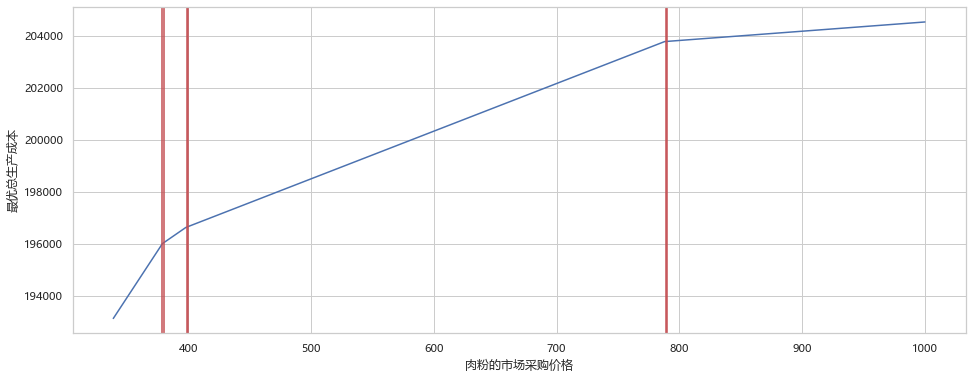

In [11]:
plt.figure(figsize=(16,6))
# plt.subplot(121)
plt.plot(price_ls,value_ls)
for x in key_price_ls:#标注变化点
    plt.axvline(x=x,c='r')
print(key_price_ls)
plt.xlabel('肉粉的市场采购价格')
plt.ylabel('最优总生产成本')

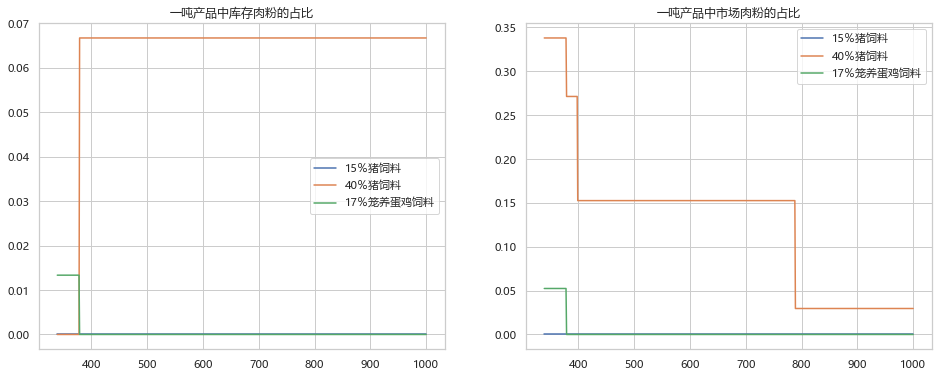

In [12]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(price_ls,x_stock_ls)
plt.title('一吨产品中库存肉粉的占比')
plt.legend(('15％猪饲料','40％猪饲料','17％笼养蛋鸡饲料'))
plt.subplot(122)
plt.plot(price_ls,x_market_ls)
plt.title('一吨产品中市场肉粉的占比')
plt.legend(('15％猪饲料','40％猪饲料','17％笼养蛋鸡饲料'))